In [1]:
import warnings
warnings.filterwarnings('ignore')
warnings.simplefilter(action='ignore', category=FutureWarning)
import os
import pandas as pd
import numpy as np
import datetime
import matplotlib.pyplot as plt
import seaborn as sns

# https://towardsdatascience.com/jypyter-notebook-shortcuts-bf0101a98330 Shortcuts

In [2]:
def inp_prep(df_o, col_drop_list=['P','Pa','ff3' , 'ff10', 'tR', 'E', 'Tg', 'E', 'sss', "E'", 'W1', 'W2', 'Unnamed: 29'], info=True, reverse=True):
    #clean cols
    dfa = df_o.drop(columns=col_drop_list)
    
    # replace NaN to mean of 2 nb
    dfa['T'] = dfa['T'].where(dfa['T'].values == 999, other=(dfa['T'].fillna(method='ffill') + dfa['T'].fillna(method='bfill'))/2)
    # datetimeindex
    dfa.index = pd.to_datetime(dfa.index, dayfirst=True)
    if info is True:
         dfa.info()
    if reverse is True:
        # reverse
        dfa = dfa.iloc[::-1]
   
    return dfa

In [3]:
def conv_wind(dfa, add_column=True):
    m_df4_ = dfa['DD'].replace(['Ветер, дующий с запада', 'Ветер, дующий с юго-запада', 'Ветер, дующий с западо-юго-запада', 'Ветер, дующий с западо-северо-запада'],'West')
    m_df4_ = m_df4_.replace(['Ветер, дующий с севера', 'Ветер, дующий с северо-запада', 'Ветер, дующий с северо-северо-востока', 'Ветер, дующий с северо-северо-запада'],'North')
    m_df4_ = m_df4_.replace(['Ветер, дующий с востока', 'Ветер, дующий с северо-востока', 'Ветер, дующий с востоко-юго-востока', 'Ветер, дующий с востоко-северо-востока'],'East')
    m_df4_ = m_df4_.replace(['Ветер, дующий с юга', 'Ветер, дующий с юго-востока', 'Ветер, дующий с юго-юго-запада', 'Ветер, дующий с юго-юго-востока'],'South')
    m_df4_ = m_df4_.replace(['Штиль, безветрие'],'Calm')
    m_df4 = dfa.copy()
    if add_column:
        m_df4['DD_'] = m_df4_
        m_df4['DD_'].unique()
    else:
        m_df4['DD'] = m_df4_
        m_df4['DD'].unique()
    return m_df4

In [116]:
# clouds values to float type
def conv_cloud(dfa, col_name='N'):
    m_df4_ = dfa[col_name].replace(['70 – 80%.'],75)
    m_df4_ = m_df4_.replace(['90  или более, но не 100%'],90)
    m_df4_ = m_df4_.replace(['60%.'],60)
    m_df4_ = m_df4_.replace(['100%.'], 100)
    m_df4_ = m_df4_.replace(['Облаков нет.'],0)
    m_df4_ = m_df4_.replace(['40%.'],40)
    m_df4_ = m_df4_.replace(['20–30%.'],25)
    m_df4_ = m_df4_.replace(['10%  или менее, но не 0'],10)
    m_df4_ = m_df4_.replace(['50%.'],50)
    m_df4_ = m_df4_.replace(['Небо не видно из-за тумана и/или других метеорологических явлений.'],101)
    m_df4 = dfa.copy()
    m_df4[col_name] = m_df4_
    m_df4[col_name].unique()
    return m_df4

In [5]:
# Conv cl to cat
 def cl_cat(cl_series):
    from sklearn import preprocessing
    le = preprocessing.LabelEncoder()
    return le.fit_transform(cl_series)

In [6]:
#precip values to float type
def conv_precip(dfa):
    m_df4_ = dfa['RRR'].replace(['Осадков нет'],0)
    m_df4_ = m_df4_.replace(['Следы осадков'],0.1)
    m_df4_ = m_df4_.astype(float)
    m_df4 = dfa.copy()
    m_df4['RRR'] = m_df4_
    return m_df4

In [7]:
#conv_wind_label
def conv_wind_label(dfa):
    m_df4_ = dfa['DD'].replace(['West'],1)
    m_df4_ = m_df4_.replace(['North'],2)
    m_df4_ = m_df4_.replace(['East'],3)
    m_df4_ = m_df4_.replace(['South'],4)
    m_df4_ = m_df4_.replace(['Calm'],0)
    m_df4 = dfa.copy()
    m_df4['DD'] = m_df4_
    m_df4['DD'].unique()
    return m_df4

In [8]:
#

Загрузка Omsk Ogimet 

In [9]:
# load ogimet (1999-)
df_ogimet = pd.read_csv('Omsk_weather_all_years.csv', index_col='Datetime')
df_ogimet.index = pd.to_datetime(df_ogimet.index)

In [10]:
# Basic clean
def clean(m_df):
    # drop dublicates
    m_df = m_df.loc[~m_df.index.duplicated(keep='first')]
    
    # replace '-----' to nan
    m_df['T(C)'].replace('-----', np.nan, inplace=True)
    m_df['Td(C)'].replace('-----', np.nan, inplace=True)
    m_df['Tmax(C)'].replace('-----', np.nan, inplace=True)
    m_df['Tmin(C)'].replace('-----', np.nan, inplace=True)
    
    m_df['T(C)'] = m_df['T(C)'].astype(float)
    m_df['Td(C)'] = m_df['Td(C)'].astype(float)
    m_df['Tmax(C)'] = m_df['Tmax(C)'].astype(float)
    m_df['Tmin(C)'] = m_df['Tmin(C)'].astype(float)
    
    # Clear incorrect
    m_df['T(C)'].replace(-90.4, np.nan, inplace=True)
    m_df['T(C)'].replace(-48.8, np.nan, inplace=True)
    m_df['T(C)'].replace(-88.0, np.nan, inplace=True)
    m_df['T(C)'].replace(50.2, np.nan, inplace=True)
    
    # replace NaN to mean of 2 nb
    m_df['T(C)'] = m_df['T(C)'].where(m_df['T(C)'].values == 999, other=(m_df['T(C)'].fillna(method='ffill') + m_df['T(C)'].fillna(method='bfill'))/2)
    
    m_df = m_df.shift(periods=2)
    m_df = m_df.iloc[2:]
    
    return m_df

df_ogimet = clean(df_ogimet)
# m_df.to_csv('Omsk_weather_last_year_cl.csv')

In [11]:
# select columns
df_ogimet = df_ogimet[['T(C)', 'ddd', 'ffkmh', 'P0hPa', 'PTnd', 'Nt']]

In [12]:
# rename wind columns value to 4 quarter
def wind_to_4q(df_ogimet):
    df = df_ogimet.copy()
    df['ddd'].replace(['W','SW','WSW','WNW'],'West', inplace=True)
    df['ddd'].replace(['N','NW','NNW','NNE'],'North', inplace=True)
    df['ddd'].replace(['E','NE','ESE','ENE'],'East', inplace=True)
    df['ddd'].replace(['S','SE','SSW','SSE'],'South', inplace=True)
    df_ogimet['ddd_'] = df['ddd']
    return df_ogimet

df_ogimet = wind_to_4q(df_ogimet)

In [13]:
df_ogimet = df_ogimet[(df_ogimet['ddd'] != 'None') & (df_ogimet['ddd'] != "`CB")]

Загрузка Омск RP5

In [14]:
# Load RP5 (Omsk)
df_omsk = pd.read_csv('RP5/28698.01.02.2005.04.05.2021.1.0.0.ru.utf8.00000000.csv', skiprows=6, sep=';', index_col=0)
df_omsk.index = pd.to_datetime(df_omsk.index, dayfirst=True)

In [15]:
df_omsk = inp_prep(df_omsk)

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 47319 entries, 2021-05-04 15:00:00 to 2005-02-01 06:00:00
Data columns (total 17 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   T       47319 non-null  float64
 1   Po      47203 non-null  float64
 2   U       47240 non-null  float64
 3   DD      47292 non-null  object 
 4   Ff      47294 non-null  float64
 5   N       47282 non-null  object 
 6   WW      47319 non-null  object 
 7   Tn      6252 non-null   float64
 8   Tx      8686 non-null   float64
 9   Cl      31497 non-null  object 
 10  Nh      39259 non-null  object 
 11  H       39332 non-null  object 
 12  Cm      28710 non-null  object 
 13  Ch      27600 non-null  object 
 14  VV      47270 non-null  object 
 15  Td      47286 non-null  float64
 16  RRR     11792 non-null  object 
dtypes: float64(7), object(10)
memory usage: 6.5+ MB


In [16]:
_1 = df_omsk['2020-01-01']['T']
_2 = df_ogimet['2020-01-01']['T(C)']
_3 = pd.merge(_1,_2, how='left', left_index=True, right_index=True)
_3.head(8)

# df_ogimet1 = pd.read_csv('Omsk_weather_all_years.csv', index_col='Datetime')
# # df_ogimet1.index = pd.to_datetime(df_ogimet1.index)
# df_ogimet1[df_ogimet1.index.str.contains('2015-01-01')]

,T,T(C)
Местное время в Омске,,
2020-01-01 00:00:00,-20.5,NaN
2020-01-01 03:00:00,-18.4,NaN
2020-01-01 06:00:00,-13.4,NaN
2020-01-01 09:00:00,-9.3,-20.5
2020-01-01 12:00:00,-6.3,-18.4
2020-01-01 15:00:00,-5.1,-5.1
2020-01-01 18:00:00,-4.2,-4.2
2020-01-01 21:00:00,-3.9,-3.9


Загрузка Аэропорт RP5

In [17]:
# Load Airport (RP5)
df_airport = pd.read_csv('RP5/UNOO.26.09.2012.04.05.2021.1.0.0.ru.utf8.00000000.csv', skiprows=6, sep=';', index_col=0)
df_airport.index = pd.to_datetime(df_airport.index, dayfirst=True)

In [18]:
df_airport = inp_prep(df_airport, col_drop_list=['Unnamed: 13', "W'W'", 'ff10'])

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 127686 entries, 2021-05-04 16:00:00 to 2012-09-26 13:00:00
Data columns (total 10 columns):
 #   Column  Non-Null Count   Dtype  
---  ------  --------------   -----  
 0   T       127686 non-null  float64
 1   P0      127681 non-null  float64
 2   P       127685 non-null  float64
 3   U       127681 non-null  float64
 4   DD      127684 non-null  object 
 5   Ff      127684 non-null  float64
 6   WW      32368 non-null   object 
 7   c       127683 non-null  object 
 8   VV      127685 non-null  object 
 9   Td      127681 non-null  float64
dtypes: float64(6), object(4)
memory usage: 10.7+ MB


In [150]:
# to one df
df_airport_ = df_airport['2012-11':'2021-02']
df_omsk_ = df_omsk['2012-11':'2021-02']

df_airport_ = df_airport_[['T', 'DD', 'Ff', 'P0', 'c']]
df_airport_ = df_airport_.rename(columns={'T':'T_a', 'DD':'DD_a', 'Ff':'Ff_a', 'P0':'P0_a', 'c':'c_a'})

df_omsk_ = df_omsk_[['T', 'Po', 'DD', 'Ff', 'N', 'Nh', 'Cl', 'U', 'Cm', 'Ch', 'H', 'RRR']] # Nh, количество всех наблюдающихся облаков Cl или, при отсутствии облаков Cl, количество всех наблюдающихся облаков Cm

df_omsk_airport_m = pd.merge(df_airport_, df_omsk_, how='inner', left_index=True, right_index=True)

In [151]:
df_omsk_airport_m['2020-11-05']

,T_a,DD_a,Ff_a,P0_a,c_a,T,Po,DD,Ff,N,Nh,Cl,U,Cm,Ch,H,RRR
2020-11-05 00:00:00,2.0,"Ветер, дующий с запада",7.0,756.8,Нет существенной облачности,1.3,754.7,"Ветер, дующий с западо-юго-запада",4.0,"90 или более, но не 100%","90 или более, но не 100%","Слоисто-кучевых, слоистых, кучевых или кучево-...",86.0,"Высококучевые просвечивающие, расположенные на...","Перистых, перисто-кучевых или перисто-слоистых...","2500 или более, или облаков нет.",NaN
2020-11-05 03:00:00,3.0,"Ветер, дующий с запада",8.0,755.4,Нет существенной облачности,2.3,754.0,"Ветер, дующий с запада",4.0,100%.,100%.,"Слоисто-кучевых, слоистых, кучевых или кучево-...",84.0,"Высококучевые просвечивающие, полосами, либо о...",NaN,"2500 или более, или облаков нет.",NaN
2020-11-05 06:00:00,1.0,"Ветер, дующий с запада",5.0,755.3,Нет существенной облачности,1.3,753.4,"Ветер, дующий с западо-юго-запада",4.0,20–30%.,Облаков нет.,"Слоисто-кучевых, слоистых, кучевых или кучево-...",90.0,"Высококучевых, высокослоистых или слоисто-дожд...","Перистые нитевидные, иногда когтевидные, не ра...","2500 или более, или облаков нет.",NaN
2020-11-05 09:00:00,1.0,"Ветер, дующий с запада",6.0,755.3,Нет существенной облачности,0.5,753.7,"Ветер, дующий с запада",3.0,20–30%.,20–30%.,"Слоисто-кучевых, слоистых, кучевых или кучево-...",91.0,Клочья (часто чечевицеобразные) высококучевых ...,"Перистых, перисто-кучевых или перисто-слоистых...","2500 или более, или облаков нет.",Осадков нет
2020-11-05 12:00:00,5.0,"Ветер, дующий с западо-северо-запада",6.0,756.1,Рассеянная (40-50%) 990 м,4.5,754.5,"Ветер, дующий с западо-северо-запада",3.0,70 – 80%.,40%.,"Слоисто-кучевых, слоистых, кучевых или кучево-...",74.0,"Высококучевые просвечивающие, расположенные на...",Перистые плотные в виде клочьев или скрученных...,"2500 или более, или облаков нет.",NaN
2020-11-05 15:00:00,8.0,"Ветер, дующий с западо-северо-запада",6.0,757.0,Нет существенной облачности,7.6,755.2,"Ветер, дующий с запада",3.0,100%.,Облаков нет.,"Слоисто-кучевых, слоистых, кучевых или кучево-...",65.0,"Высококучевых, высокослоистых или слоисто-дожд...",Перистые когтевидные или нитевидные или первые...,"2500 или более, или облаков нет.",NaN
2020-11-05 18:00:00,1.0,"Ветер, дующий с запада",4.0,757.6,Рассеянная (40-50%) 1200 м,4.2,756.1,"Ветер, дующий с юго-запада",2.0,40%.,Облаков нет.,"Слоисто-кучевых, слоистых, кучевых или кучево-...",79.0,"Высококучевых, высокослоистых или слоисто-дожд...",Перистые когтевидные или нитевидные или первые...,"2500 или более, или облаков нет.",NaN
2020-11-05 21:00:00,-1.0,"Ветер, дующий с юго-запада",2.0,757.5,Нет существенной облачности,1.7,756.2,"Ветер, дующий с юго-юго-запада",1.0,20–30%.,Облаков нет.,"Слоисто-кучевых, слоистых, кучевых или кучево-...",88.0,"Высококучевых, высокослоистых или слоисто-дожд...","Перистые нитевидные, иногда когтевидные, не ра...","2500 или более, или облаков нет.",Осадков нет


In [170]:
df_omsk_airport_m1 = df_omsk_airport_m[['T', 'T_a', 'DD', 'Ff', 'N', 'Nh', 'Cl', 'Po', 'U', 'Ch', 'Cm', 'H', 'RRR']]
df_omsk_airport_m1 = conv_wind(df_omsk_airport_m1)
df_omsk_airport_m1 = conv_cloud(df_omsk_airport_m1)
df_omsk_airport_m1 = conv_cloud(df_omsk_airport_m1, col_name='Nh')
# df_omsk_airport_m1['Cl'] = cl_cat(df_omsk_airport_m1['Cl'])
# df_omsk_airport_m1 = df_omsk_airport_m1.drop(columns=['DD'])

#
df_omsk_airport_m1

,T,T_a,Ff,N,Nh,Cl,Po,U,Ch,Cm,H,RRR,DD_
2012-11-01 00:00:00,-1.9,-6.0,3.0,0.0,NaN,10,763.7,75.0,NaN,NaN,NaN,NaN,North
2012-11-01 03:00:00,-3.7,-7.0,2.0,10.0,10.0,7,764.9,83.0,"Перистых, перисто-кучевых или перисто-слоистых...","Высококучевые просвечивающие, расположенные на...","2500 или более, или облаков нет.",NaN,North
2012-11-01 06:00:00,-5.1,-7.0,1.0,100.0,0.0,7,766.4,90.0,"Перистые нитевидные, иногда когтевидные, не ра...","Высококучевых, высокослоистых или слоисто-дожд...","2500 или более, или облаков нет.",NaN,North
2012-11-01 09:00:00,-6.6,-8.0,1.0,0.0,NaN,10,767.6,94.0,NaN,NaN,NaN,Осадков нет,North
2012-11-01 12:00:00,0.9,0.0,1.0,100.0,0.0,7,768.6,64.0,"Перисто-кучевые одни или перисто-кучевые, сопр...","Высококучевых, высокослоистых или слоисто-дожд...","2500 или более, или облаков нет.",NaN,West
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-02-28 09:00:00,-25.8,-24.0,3.0,100.0,100.0,7,755.8,79.0,NaN,Высокослоистые просвечивающие.,"2500 или более, или облаков нет.",Следы осадков,East
2021-02-28 12:00:00,-20.7,-20.0,4.0,100.0,0.0,7,753.9,81.0,Перистые (часто в виде полос) и перисто-слоист...,"Высококучевых, высокослоистых или слоисто-дожд...","2500 или более, или облаков нет.",NaN,East
2021-02-28 15:00:00,-17.2,-17.0,5.0,100.0,40.0,7,751.9,80.0,Перистые (часто в виде полос) и перисто-слоист...,Высокослоистые непросвечивающие или слоисто-до...,"2500 или более, или облаков нет.",NaN,East
2021-02-28 18:00:00,-17.3,-17.0,6.0,100.0,100.0,0,750.1,82.0,NaN,NaN,600-1000,NaN,East


In [171]:
# select winter periods:
def select_winter_p(df):
    range_1 = df.loc['2005-11':'2006-02']
    range_2 = df.loc['2006-11':'2007-02']
    range_3 = df.loc['2007-11':'2008-02']
    range_4 = df.loc['2008-11':'2009-02']
    range_5 = df.loc['2009-11':'2010-02']
    range_6 = df.loc['2010-11':'2011-02']
    range_7 = df.loc['2011-11':'2012-02']
    range_8 = df.loc['2012-11':'2013-02']
    range_9 = df.loc['2013-11':'2014-02']
    range_10 = df.loc['2014-11':'2015-02']
    range_11 = df.loc['2015-11':'2016-02']
    range_12 = df.loc['2016-11':'2017-02']
    range_13 = df.loc['2017-11':'2018-02']
    range_14 = df.loc['2018-11':'2019-02']
    range_15 = df.loc['2019-11':'2020-02']
    range_16 = df.loc['2020-11':'2021-02']
    
    return pd.concat([range_1, range_2, range_3, range_4, range_5, range_6, range_7, range_8, range_9, range_10, range_11, range_12, range_13, range_14, range_15, range_16])

df_omsk_airport_winter = select_winter_p(df_omsk_airport_m1)

In [172]:
df_omsk_airport_winter['diff'] = df_omsk_airport_winter['T'] - df_omsk_airport_winter['T_a']
df_omsk_airport_winter['abs_diff'] = abs(df_omsk_airport_winter['T'] - df_omsk_airport_winter['T_a'])

In [173]:
# show
df_omsk_airport_winter_1 = df_omsk_airport_winter[abs(df_omsk_airport_winter['diff']) > 1 ]
df_omsk_airport_winter_1.groupby('DD_', as_index=False)['diff', 'abs_diff'].mean().sort_values('abs_diff', ascending=False)

,DD_,diff,abs_diff
0,Calm,-0.714453,2.191797
2,North,-1.055755,1.955036
4,West,1.816511,1.948336
3,South,1.605505,1.880505
1,East,-1.378390,1.807768


<AxesSubplot:ylabel='DD_'>

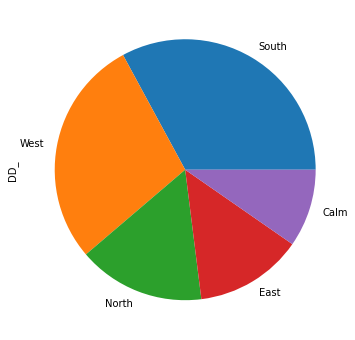

In [174]:
# Роза ветров
df_omsk_airport_winter_1['DD_'].value_counts().plot(kind='pie')

In [157]:
# кореляция
df_omsk_airport_winter_1_ = df_omsk_airport_winter_1.copy()
df_omsk_airport_winter_1_['DD_'] = df_omsk_airport_winter_1['DD_'].astype('category').cat.codes
df_omsk_airport_winter_1_.corr()

,T,T_a,Ff,N,Nh,Cl,Po,U,DD_,diff,abs_diff
T,1.000000,0.969294,0.232996,0.404225,0.273508,-0.388843,-0.450902,0.244388,0.330011,0.327274,-0.112759
T_a,0.969294,1.000000,0.237126,0.417168,0.314300,-0.404973,-0.455679,0.260673,0.194936,0.084862,-0.136584
Ff,0.232996,0.237126,1.000000,0.162324,0.127062,-0.151011,-0.241620,-0.198885,0.224522,0.032894,-0.180046
N,0.404225,0.417168,0.162324,1.000000,0.532074,-0.690075,-0.312586,0.195935,0.061651,0.034970,-0.192263
Nh,0.273508,0.314300,0.127062,0.532074,1.000000,-0.227022,-0.259035,0.297302,-0.022680,-0.131084,-0.189691
Cl,-0.388843,-0.404973,-0.151011,-0.690075,-0.227022,1.000000,0.325301,-0.174127,-0.109000,-0.019397,0.169326
Po,-0.450902,-0.455679,-0.241620,-0.312586,-0.259035,0.325301,1.000000,-0.261043,-0.214912,-0.075970,0.137009
U,0.244388,0.260673,-0.198885,0.195935,0.297302,-0.174127,-0.261043,1.000000,-0.003504,-0.011202,-0.052169
DD_,0.330011,0.194936,0.224522,0.061651,-0.022680,-0.109000,-0.214912,-0.003504,1.000000,0.588114,-0.037916
diff,0.327274,0.084862,0.032894,0.034970,-0.131084,-0.019397,-0.075970,-0.011202,0.588114,1.000000,0.067952


In [158]:
df_omsk_airport_winter_1_['2014-12'].corr()

,T,T_a,Ff,N,Nh,Cl,Po,U,DD_,diff,abs_diff
T,1.000000,0.962741,0.118918,0.486177,0.269238,-0.287725,-0.153425,0.430028,0.128609,0.211455,-0.209217
T_a,0.962741,1.000000,0.153896,0.593966,0.320455,-0.381656,-0.234359,0.396056,-0.065208,-0.060735,-0.105713
Ff,0.118918,0.153896,1.000000,0.357024,0.284306,-0.243318,-0.351119,-0.323901,0.001983,-0.117289,-0.249304
N,0.486177,0.593966,0.357024,1.000000,0.495143,-0.806071,-0.357728,0.181470,-0.213096,-0.352242,-0.352648
Nh,0.269238,0.320455,0.284306,0.495143,1.000000,0.340272,-0.206659,0.140066,0.102075,-0.182395,-0.146402
Cl,-0.287725,-0.381656,-0.243318,-0.806071,0.340272,1.000000,0.110174,0.020438,0.179919,0.317393,0.381449
Po,-0.153425,-0.234359,-0.351119,-0.357728,-0.206659,0.110174,1.000000,-0.115459,0.234929,0.280735,-0.098650
U,0.430028,0.396056,-0.323901,0.181470,0.140066,0.020438,-0.115459,1.000000,-0.025743,0.155806,-0.066214
DD_,0.128609,-0.065208,0.001983,-0.213096,0.102075,0.179919,0.234929,-0.025743,1.000000,0.710378,-0.415575
diff,0.211455,-0.060735,-0.117289,-0.352242,-0.182395,0.317393,0.280735,0.155806,0.710378,1.000000,-0.390153


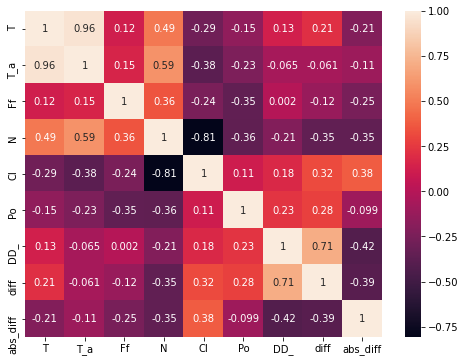

In [101]:
sns.heatmap(df_omsk_airport_winter_1_['2014-12'].corr(), annot=True)
plt.rcParams["figure.figsize"] = (12,6)
plt.show()

In [102]:
df_omsk_airport_winter_1_['2014-12'].cov() # WRONG - different scales

,T,T_a,Ff,N,Cl,Po,DD_,diff,abs_diff
T,47.398769,44.683364,1.056473,153.931791,-2.845342,-7.265623,1.046703,2.715405,-0.977680
T_a,44.683364,45.447066,1.338778,184.147005,-3.695705,-10.867453,-0.519661,-0.763702,-0.483727
Ff,1.056473,1.338778,1.665154,21.187235,-0.450998,-3.116546,0.003025,-0.282305,-0.218361
N,153.931791,184.147005,21.187235,2114.950091,-53.247126,-113.160768,-11.584997,-30.215215,-11.008016
Cl,-2.845342,-3.695705,-0.450998,-53.247126,2.063218,1.088536,0.305505,0.850363,0.371900
Po,-7.265623,-10.867453,-3.116546,-113.160768,1.088536,47.313482,1.910284,3.601830,-0.460584
DD_,1.046703,-0.519661,0.003025,-11.584997,0.305505,1.910284,1.397459,1.566364,-0.333454
diff,2.715405,-0.763702,-0.282305,-30.215215,0.850363,3.601830,1.566364,3.479108,-0.493953
abs_diff,-0.977680,-0.483727,-0.218361,-11.008016,0.371900,-0.460584,-0.333454,-0.493953,0.460717


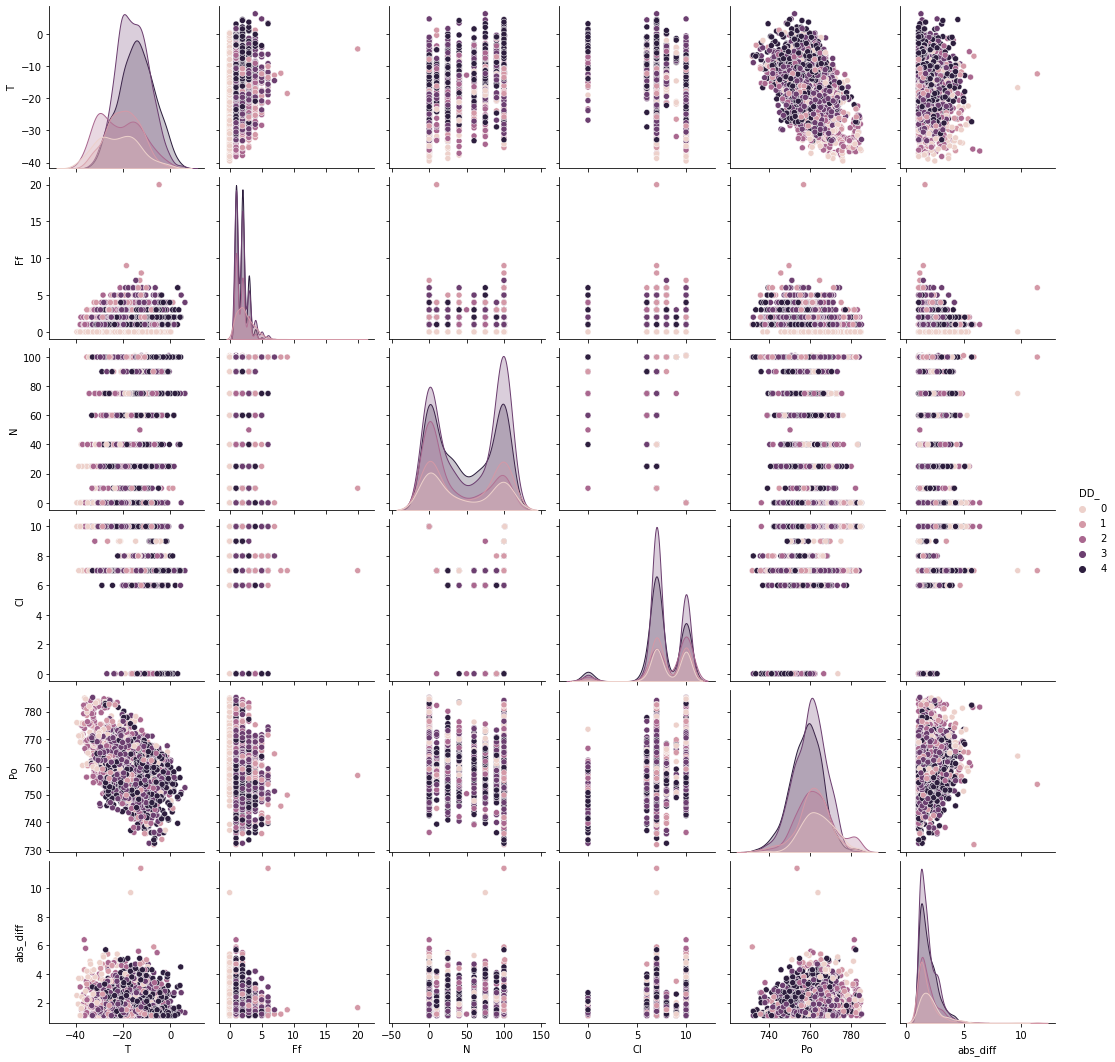

In [108]:
df_omsk_airport_winter_1_pairp = df_omsk_airport_winter_1_.drop(columns=['T_a', 'diff'])
# Графики
sns.pairplot(df_omsk_airport_winter_1_pairp, hue="DD_")

<AxesSubplot:xlabel='diff', ylabel='DD_'>

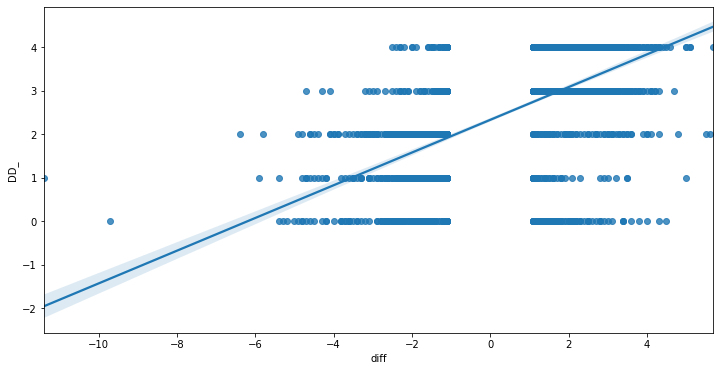

In [111]:
sns.regplot(x="diff", y="DD_", data=df_omsk_airport_winter_1_)

Загрузка Калачинск

In [175]:
# load kal
df_kal = pd.read_csv('RP5/28696.01.02.2005.03.05.2021.1.0.0.ru.utf8.00000000.csv', skiprows=6, sep=';', index_col=0)
df_kal.index = pd.to_datetime(df_kal.index, dayfirst=True)

In [176]:
# sel cols
df_kal = df_kal[['T']]
df_kal = df_kal.rename(columns={'T':'T_kal'})

Загрузка Шербакуль

In [177]:
# load sherb
df_sher = pd.read_csv('RP5/28791.01.02.2005.04.05.2021.1.0.0.ru.utf8.00000000.csv', skiprows=6, sep=';', index_col=0)
df_sher.index = pd.to_datetime(df_sher.index, dayfirst=True)

In [178]:
# sel cols
df_sher = df_sher[['T']]
df_sher = df_sher.rename(columns={'T':'T_sher'})

Загрузка Саргатское

In [179]:
# load sar
df_sar = pd.read_csv('RP5/28598.01.02.2005.04.05.2021.1.0.0.ru.utf8.00000000.csv', skiprows=6, sep=';', index_col=0)
df_sar.index = pd.to_datetime(df_sar.index, dayfirst=True)

In [180]:
# sel cols
df_sar = df_sar[['T']]
df_sar = df_sar.rename(columns={'T':'T_sar'})

In [181]:
# # to one df
df_three = pd.concat([df_kal, df_sher, df_sar], axis=1)

# select winter periods
df_three_w = select_winter_p(df_three)

In [182]:
df_three_w['three_mean'] = df_three_w[['T_kal', 'T_sher', 'T_sar']].mean(axis=1, skipna=False) # skipna=False Thinking about it???

In [183]:
# add omsk and airport
df_merged = df_omsk_airport_winter.merge(df_three_w, how = 'inner', left_index=True, right_index=True)

df_merged['diff_3'] = df_merged['T'] - df_merged['three_mean']
df_merged['abs_diff_3'] = abs(df_merged['T'] - df_merged['three_mean'])

df_merged1 = df_merged.drop(columns=['T_kal', 'T_sher', 'T_sar'])
df_merged1
# save a new df
# df_merged.to_csv('df_merged')

,T,T_a,Ff,N,Nh,Cl,Po,U,Ch,Cm,H,RRR,DD_,diff,abs_diff,three_mean,diff_3,abs_diff_3
2012-11-01 00:00:00,-1.9,-6.0,3.0,0.0,NaN,10,763.7,75.0,NaN,NaN,NaN,NaN,North,4.1,4.1,-4.266667,2.366667,2.366667
2012-11-01 03:00:00,-3.7,-7.0,2.0,10.0,10.0,7,764.9,83.0,"Перистых, перисто-кучевых или перисто-слоистых...","Высококучевые просвечивающие, расположенные на...","2500 или более, или облаков нет.",NaN,North,3.3,3.3,-5.300000,1.600000,1.600000
2012-11-01 06:00:00,-5.1,-7.0,1.0,100.0,0.0,7,766.4,90.0,"Перистые нитевидные, иногда когтевидные, не ра...","Высококучевых, высокослоистых или слоисто-дожд...","2500 или более, или облаков нет.",NaN,North,1.9,1.9,-6.933333,1.833333,1.833333
2012-11-01 09:00:00,-6.6,-8.0,1.0,0.0,NaN,10,767.6,94.0,NaN,NaN,NaN,Осадков нет,North,1.4,1.4,-7.533333,0.933333,0.933333
2012-11-01 12:00:00,0.9,0.0,1.0,100.0,0.0,7,768.6,64.0,"Перисто-кучевые одни или перисто-кучевые, сопр...","Высококучевых, высокослоистых или слоисто-дожд...","2500 или более, или облаков нет.",NaN,West,0.9,0.9,-0.133333,1.033333,1.033333
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-02-28 09:00:00,-25.8,-24.0,3.0,100.0,100.0,7,755.8,79.0,NaN,Высокослоистые просвечивающие.,"2500 или более, или облаков нет.",Следы осадков,East,-1.8,1.8,-25.500000,-0.300000,0.300000
2021-02-28 12:00:00,-20.7,-20.0,4.0,100.0,0.0,7,753.9,81.0,Перистые (часто в виде полос) и перисто-слоист...,"Высококучевых, высокослоистых или слоисто-дожд...","2500 или более, или облаков нет.",NaN,East,-0.7,0.7,-20.800000,0.100000,0.100000
2021-02-28 15:00:00,-17.2,-17.0,5.0,100.0,40.0,7,751.9,80.0,Перистые (часто в виде полос) и перисто-слоист...,Высокослоистые непросвечивающие или слоисто-до...,"2500 или более, или облаков нет.",NaN,East,-0.2,0.2,-16.700000,-0.500000,0.500000
2021-02-28 18:00:00,-17.3,-17.0,6.0,100.0,100.0,0,750.1,82.0,NaN,NaN,600-1000,NaN,East,-0.3,0.3,-16.833333,-0.466667,0.466667


### Сравнение

In [74]:
#  compare
df_merged1.groupby('DD_', as_index=False)[['diff_3', 'abs_diff_3']].mean()

,DD_,diff_3,abs_diff_3
0,Calm,1.048747,1.637054
1,East,0.635767,1.003941
2,North,0.455882,0.863841
3,South,0.785247,1.151192
4,West,0.716323,0.991239


In [77]:
df_merged1_ = df_merged1[abs(df_merged1['diff_3']) > 1 ]
df_merged1_.groupby('DD_', as_index=False)['diff_3', 'abs_diff_3'].mean().sort_values('abs_diff_3', ascending=False)

,DD_,diff_3,abs_diff_3
0,Calm,1.661004,2.465637
4,West,1.968357,2.289765
3,South,1.883316,2.271315
1,East,1.532194,2.045983
2,North,1.342812,1.925891


In [78]:
df_merged1_[df_merged1_['T'] <= -15].groupby('DD_', as_index=False)[['diff_3', 'abs_diff_3']].mean()

,DD_,diff_3,abs_diff_3
0,Calm,1.758961,2.531004
1,East,1.730556,2.121181
2,North,1.373965,1.911002
3,South,2.172328,2.496756
4,West,2.214902,2.445490


In [79]:
df_merged1_[df_merged1_['T'] <= -20].groupby('DD_', as_index=False)[['diff_3', 'abs_diff_3']].mean()

,DD_,diff_3,abs_diff_3
0,Calm,2.085600,2.405600
1,East,1.960185,2.153704
2,North,1.495566,1.898930
3,South,2.360179,2.663087
4,West,2.399630,2.490370


In [80]:
df_merged1_[df_merged1_['T'] <= -25].groupby('DD_', as_index=False)[['diff_3', 'abs_diff_3']].mean()

,DD_,diff_3,abs_diff_3
0,Calm,2.139827,2.280087
1,East,2.075720,2.202469
2,North,1.504487,1.833120
3,South,2.730421,2.797087
4,West,2.585417,2.637917


<AxesSubplot:ylabel='Density'>

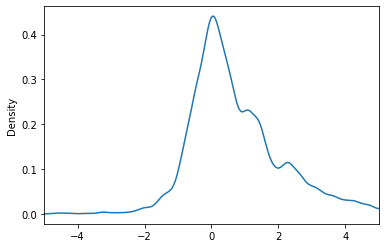

In [86]:
df_merged1[(df_merged1['DD_'] == 'South')]['diff_3'].plot.kde(bw_method=0.1, xlim=(-5,5))

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4 entries, 0 to 3
Data columns (total 4 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   index   4 non-null      int64  
 1   mean    4 non-null      float64
 2   min     4 non-null      float64
 3   max     4 non-null      float64
dtypes: float64(3), int64(1)
memory usage: 256.0 bytes


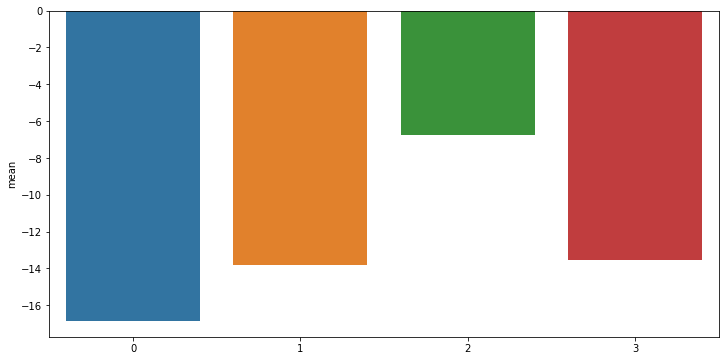

In [190]:
by_month = (df_merged.groupby(df_merged.index.month)['T']
                              .agg(['mean', 'min', 'max'])
                              .reset_index())
by_month.info()

ax = sns.barplot(x=by_month.index, y="mean", data=by_month)

In [192]:
# df_merged.index.hour

Int64Index([ 0,  3,  6,  9, 12, 15, 18, 21,  0,  3,
            ...
            15, 18, 21,  3,  6,  9, 12, 15, 18, 21],
           dtype='int64', length=8499)

In [194]:
# have tried named aggregation

df_merged.groupby('DD_').agg(
             diff=('diff', 'mean'),
             abs_diff=('abs_diff', 'mean'),
            d_range=('diff', lambda x: x.max() - x.min())
)

,diff,abs_diff,d_range
DD_,,,
Calm,-0.357803,1.315029,14.2
East,-0.608401,0.894295,16.4
North,-0.594120,1.053935,12.0
South,0.493044,0.850911,9.4
West,0.542034,0.815480,8.2


In [197]:
df_merged.groupby('Ch', as_index=False)['Cl'].size()

,Ch,size
0,"Перисто-кучевые одни или перисто-кучевые, сопр...",164
1,"Перисто-слоистые, покрывающие все небо.",27
2,Перистые (часто в виде полос) и перисто-слоист...,126
3,Перистые (часто в виде полос) и перисто-слоист...,1
4,Перистые когтевидные или нитевидные или первые...,27
5,"Перистые нитевидные, иногда когтевидные, не ра...",1874
6,Перистые плотные в виде клочьев или скрученных...,187
7,"Перистые плотные, образовавшиеся от кучево-дож...",3
8,"Перистых, перисто-кучевых или перисто-слоистых...",610


In [201]:
# custom sum function
from functools import reduce
def test_sum(series):
    return reduce(lambda x, y: x + y, series)
df_merged.groupby('T').agg({'T': ['sum', test_sum]})

T         
        sum test_sum
T                   
-39.9 -39.9    -39.9
-39.5 -39.5    -39.5
-38.9 -38.9    -38.9
-38.7 -38.7    -38.7
-38.1 -76.2    -76.2
...     ...      ...
 8.9    8.9      8.9
 9.4    9.4      9.4
 9.8    9.8      9.8
 10.0  10.0     10.0
 10.2  10.2     10.2

[458 rows x 2 columns]

In [184]:
%store df_merged

Stored 'df_merged' (DataFrame)
